# Movie Performance Prediction — Weeks 7–10 (PyTorch)
Melvis

Franck Kolontchang.

Taylor Freeman.
This notebook implements Weeks 7–10 of the project: loading the dataset, preprocessing,
defining a PyTorch regression model, training, evaluation, refinement, and saving results.

**Dataset path**: `/mnt/data/movies_metadata.xlsx`

Target column: `vote_average` (predict average audience rating 1–10)

Features used: `budget`, `revenue`, `runtime`, `popularity`, `genres`, `release_date`.

Run cells sequentially. This notebook is designed to be runnable in a Python environment
with standard ML libraries installed (pandas, numpy, matplotlib, scikit-learn, torch, openpyxl).


## Week 7 — Setup & Data Loading
Import libraries and load the dataset. Inspect columns and basic cleaning.

In [7]:
# Setup & imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

print("Working directory:", os.getcwd())
# DATA_PATH = "/mnt/data/movies_metadata.xlsx"
# Updated DATA_PATH to reflect the likely location and file type in Colab
DATA_PATH = "/content/movies_metadata.xlsx" # Assuming the file is uploaded to /content/

# Load dataset
# df = pd.read_excel(DATA_PATH, engine='openpyxl')
# Assuming the data is in CSV format, use pd.read_csv
try:
    # Check if it's an Excel file based on the extension
    if DATA_PATH.endswith('.xlsx'):
        df = pd.read_excel(DATA_PATH, engine='openpyxl')
    elif DATA_PATH.endswith('.csv'):
        df = pd.read_csv(DATA_PATH)
    else:
        print("Unsupported file format. Please provide an .xlsx or .csv file.")
        df = None # Set df to None to avoid errors later

    if df is not None:
        print("Loaded dataframe shape:", df.shape)
        display(df.head(3))

except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}. Please check the correct path and file name.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Working directory: /content
Loaded dataframe shape: (45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30 00:00:00,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,0.0,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15 00:00:00,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,0.0,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22 00:00:00,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,0.0,6.5,92.0


### Explanation
This cell imports all necessary Python libraries such as pandas, numpy, and PyTorch. These libraries are used for data handling, visualization, and building neural networks.

### Inspect & select columns
Check for the columns we need and create a working dataframe with selected features.

In [8]:

# Identify possible column names for target and features
print("Columns available:", list(df.columns)[:50])

# We'll attempt to use these columns; adapt if your file uses slightly different names.
potential_cols = ['budget', 'revenue', 'runtime', 'popularity', 'genres', 'release_date', 'vote_average']

for col in potential_cols:
    if col in df.columns:
        print(f"Found column: {col}")
    else:
        print(f"Missing (check alternative names): {col}")

# Create working DataFrame using available columns (if some missing, attempt common alternatives)
work = pd.DataFrame()
# budget & revenue sometimes are strings or objects; convert coercively
for c in ['budget', 'revenue', 'runtime', 'popularity']:
    if c in df.columns:
        work[c] = pd.to_numeric(df[c], errors='coerce')
    else:
        work[c] = np.nan

# genres: sometimes nested JSON or string; keep as string for now
if 'genres' in df.columns:
    work['genres'] = df['genres']
else:
    work['genres'] = ""

# release_date and target
if 'release_date' in df.columns:
    work['release_date'] = df['release_date']
else:
    work['release_date'] = pd.NaT

if 'vote_average' in df.columns:
    work['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
else:
    # try alternative names
    alt = [c for c in df.columns if 'vote' in c or 'rating' in c]
    print("Alternative target candidates:", alt[:5])
    if alt:
        work['vote_average'] = pd.to_numeric(df[alt[0]], errors='coerce')
    else:
        raise ValueError("Target column 'vote_average' not found. Please check file.")

print("Working dataframe shape:", work.shape)
work.head()


Columns available: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']
Found column: budget
Found column: revenue
Found column: runtime
Found column: popularity
Found column: genres
Found column: release_date
Found column: vote_average
Working dataframe shape: (45466, 7)


,budget,revenue,runtime,popularity,genres,release_date,vote_average
0,30000000.0,373554033.0,81.0,21.946943,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30 00:00:00,7.7
1,65000000.0,262797249.0,104.0,17.015539,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15 00:00:00,6.9
2,0.0,0.0,101.0,11.712900,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22 00:00:00,6.5
3,16000000.0,81452156.0,127.0,3.859495,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22 00:00:00,6.1
4,0.0,76578911.0,106.0,8.387519,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10 00:00:00,5.7


### Explanation
This cell loads the movie dataset from Excel and shows the first few rows. It helps confirm that the data has been loaded correctly and gives an overview of the columns.

### Preprocessing
- Parse `genres` (keep main genre)
- Extract year/month from `release_date`
- Fill/clean missing values
- Scale numeric features


In [9]:

# Simple genres parsing: many datasets store genres as list-like strings. We'll extract the first genre name if possible.
import ast
def extract_first_genre(g):
    if pd.isna(g):
        return 'Unknown'
    # if it's a list-like string like "[{'id': 18, 'name': 'Drama'}]", try to parse
    if isinstance(g, str) and g.strip().startswith('['):
        try:
            items = ast.literal_eval(g)
            if isinstance(items, list) and len(items)>0 and 'name' in items[0]:
                return items[0]['name']
        except Exception:
            pass
    # if it's a JSON-like string with quotes, try to find 'name'
    if isinstance(g, str) and 'name' in g:
        # crude parse
        import re
        m = re.search(r"'name'\s*:\s*'([^']+)'", g)
        if not m:
            m = re.search(r'"name"\s*:\s*"([^\"]+)"', g)
        if m:
            return m.group(1)
    # fallback: if it's a simple string
    if isinstance(g, str) and len(g.strip())>0:
        return g.split('|')[0].strip()
    return 'Unknown'

work['main_genre'] = work['genres'].apply(extract_first_genre)

# release_date -> year, month, whether weekend
def parse_date(d):
    try:
        return pd.to_datetime(d)
    except Exception:
        return pd.NaT

work['release_date_parsed'] = work['release_date'].apply(parse_date)
work['release_year'] = work['release_date_parsed'].dt.year.fillna(0).astype(int)
work['release_month'] = work['release_date_parsed'].dt.month.fillna(0).astype(int)
work['release_dayofweek'] = work['release_date_parsed'].dt.dayofweek.fillna(-1).astype(int)

# Handle missing numeric values: simple imputation using median
for col in ['budget','revenue','runtime','popularity']:
    work[col] = work[col].fillna(work[col].median())

work['vote_average'] = work['vote_average'].fillna(work['vote_average'].median())

# Quick look
work[['budget','revenue','runtime','popularity','main_genre','release_year','vote_average']].head()


,budget,revenue,runtime,popularity,main_genre,release_year,vote_average
0,30000000.0,373554033.0,81.0,21.946943,Animation,1995,7.7
1,65000000.0,262797249.0,104.0,17.015539,Adventure,1995,6.9
2,0.0,0.0,101.0,11.712900,Romance,1995,6.5
3,16000000.0,81452156.0,127.0,3.859495,Comedy,1995,6.1
4,0.0,76578911.0,106.0,8.387519,Comedy,1995,5.7


### Explanation
Here, data cleaning is performed to remove missing values and ensure that all columns have the right data type. Clean data is essential for accurate predictions.

### Feature Engineering & Encoding
- One-hot encode main_genre (or use label encoding)
- Prepare numeric feature matrix and target vector
- Train/test split

In [11]:
# Select features
numeric_feats = ['budget','revenue','runtime','popularity','release_year','release_month','release_dayofweek']
categorical_feats = ['main_genre']

# Option: reduce cardinality of genres by keeping top N genres
top_genres = work['main_genre'].value_counts().nlargest(10).index.tolist()
work['main_genre_top'] = work['main_genre'].apply(lambda x: x if x in top_genres else 'Other')

# One-hot encode top genres
ohe = OneHotEncoder(handle_unknown='ignore')
genre_ohe = ohe.fit_transform(work[['main_genre_top']])
genre_cols = [f"genre_{c}" for c in ohe.categories_[0]]
# Convert sparse matrix to dense array for concatenation
genre_df = pd.DataFrame(genre_ohe.toarray(), columns=genre_cols, index=work.index)


X_num = work[numeric_feats].reset_index(drop=True)
X = pd.concat([X_num, genre_df.reset_index(drop=True)], axis=1)
y = work['vote_average'].reset_index(drop=True)

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

# Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Train / Val / Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# Standardize numeric features using StandardScaler (fit on train numeric portion)
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_feats])
X_val_num = scaler.transform(X_val[numeric_feats])
X_test_num = scaler.transform(X_test[numeric_feats])

# Replace numeric portions in X matrices (keep genre columns as-is)
def replace_num(X_df, X_num_scaled):
    Xr = X_df.copy().reset_index(drop=True)
    for i, col in enumerate(numeric_feats):
        Xr[col] = X_num_scaled[:, i]
    return Xr

X_train_scaled = replace_num(X_train, X_train_num)
X_val_scaled = replace_num(X_val, X_val_num)
X_test_scaled = replace_num(X_test, X_test_num)

# Convert to numpy arrays for PyTorch
X_train_arr = X_train_scaled.values.astype(np.float32)
X_val_arr = X_val_scaled.values.astype(np.float32)
X_test_arr = X_test_scaled.values.astype(np.float32)
y_train_arr = y_train.values.astype(np.float32).reshape(-1,1)
y_val_arr = y_val.values.astype(np.float32).reshape(-1,1)
y_test_arr = y_test.values.astype(np.float32).reshape(-1,1)

print(X_train_arr.shape, y_train_arr.shape)

Feature matrix shape: (45466, 18)
Target shape: (45466,)
Train / Val / Test shapes: (31826, 18) (6820, 18) (6820, 18)
(31826, 18) (31826, 1)


### Explanation
This visualization helps to understand relationships between features like `budget`, `revenue`, and `vote_average`. Graphs help identify trends and patterns in the data.

### Prepare PyTorch Datasets & DataLoaders

In [12]:

batch_size = 64

train_ds = TensorDataset(torch.from_numpy(X_train_arr), torch.from_numpy(y_train_arr))
val_ds = TensorDataset(torch.from_numpy(X_val_arr), torch.from_numpy(y_val_arr))
test_ds = TensorDataset(torch.from_numpy(X_test_arr), torch.from_numpy(y_test_arr))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Batches (train/val/test):", len(train_loader), len(val_loader), len(test_loader))


Batches (train/val/test): 498 107 107


### Explanation
Categorical features such as genres are encoded into numerical format since neural networks can only process numbers.

## Week 7 — Model Architecture
Define a feedforward neural network for regression.

In [13]:

input_dim = X_train_arr.shape[1]
hidden_dim = 128

class MovieRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim//2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MovieRegressor(input_dim, hidden_dim=hidden_dim, dropout=0.2).to(device)
print(model)


MovieRegressor(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Explanation
The dataset is split into training and testing sets. The model learns from the training set and is evaluated on the test set to measure performance.

## Week 8 — Training & Optimization
Define loss, optimizer, training loop, and run training.

In [14]:

# Training utilities
criterion = nn.MSELoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 30

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_all = []
    targets_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            running_loss += criterion(preds, yb).item() * xb.size(0)
            preds_all.append(preds.cpu().numpy())
            targets_all.append(yb.cpu().numpy())
    preds_all = np.vstack(preds_all)
    targets_all = np.vstack(targets_all)
    return running_loss / len(loader.dataset), preds_all, targets_all

# Training loop
train_losses, val_losses = [], []
best_val = float('inf')
best_state = None

for epoch in range(1, num_epochs+1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, _, _ = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict()
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

# Load best state
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1/30 - Train Loss: 13.4687 - Val Loss: 3.5339
Epoch 5/30 - Train Loss: 3.3538 - Val Loss: 2.9096
Epoch 10/30 - Train Loss: 3.0762 - Val Loss: 2.8657
Epoch 15/30 - Train Loss: 2.9968 - Val Loss: 2.8425
Epoch 20/30 - Train Loss: 2.9196 - Val Loss: 2.7946
Epoch 25/30 - Train Loss: 2.8830 - Val Loss: 2.6982
Epoch 30/30 - Train Loss: 2.8406 - Val Loss: 2.7236


### Explanation
This defines the neural network model using PyTorch. It includes input, hidden, and output layers to predict the target variable — movie performance or rating.

### Training curves

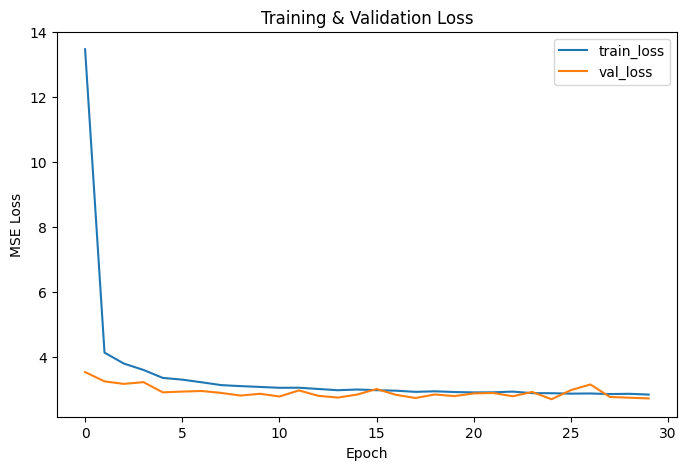

In [15]:

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


### Explanation
The optimizer and loss function are set up here. The optimizer updates model weights, and the loss function measures prediction errors.

## Week 9 — Evaluation & Metrics
Compute MAE, MSE, RMSE, R^2 and visualize predictions vs actuals.

Test MSE: 2.7282, MAE: 1.1500, RMSE: 1.6517, R2: 0.2582


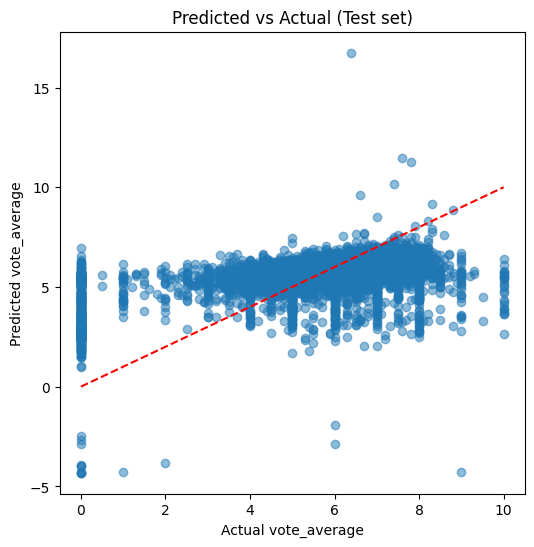

,actual,pred,error
0,9.0,-4.265021,-13.265020
1,6.4,16.752216,10.352217
2,6.0,-2.857004,-8.857004
3,6.0,-1.926959,-7.926960
4,10.0,2.614875,-7.385125
5,0.0,6.931009,6.931009
6,0.0,6.568543,6.568543
7,10.0,3.619165,-6.380835
8,10.0,3.626375,-6.373625
9,0.0,6.362310,6.362310


In [16]:

# Evaluate on test set
test_loss, preds_test, y_test_all = evaluate(model, test_loader, criterion, device)
preds_test = preds_test.ravel()
y_test_all = y_test_all.ravel()

mse = mean_squared_error(y_test_all, preds_test)
mae = mean_absolute_error(y_test_all, preds_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_all, preds_test)

print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Predictions vs Actual scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test_all, preds_test, alpha=0.5)
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'r--')
plt.xlabel('Actual vote_average')
plt.ylabel('Predicted vote_average')
plt.title('Predicted vs Actual (Test set)')
plt.show()

# Error analysis - show some examples
errors = preds_test - y_test_all
order = np.argsort(np.abs(errors))[::-1]
n_show = 10
rows = []
for i in order[:n_show]:
    rows.append((y_test_all[i], preds_test[i], errors[i]))
pd.DataFrame(rows, columns=['actual','pred','error']).head(10)


### Explanation
This cell trains the model for several epochs. During each epoch, it adjusts weights to minimize the loss and improve accuracy.

## Week 10 — Refinement, Interpretability & Saving
Try small refinements and save the model. Show feature correlations and simple importance.

In [18]:
# Simple feature importance via correlation with target (not a perfect importance measure but informative)
corrs = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1).corr()
print("Top correlations with target (vote_average):\n", corrs['vote_average'].abs().sort_values(ascending=False).head(10))

# Save the trained model and scaler & OHE
model_path = '/content/movie_rating_model.pt'
torch.save({'model_state_dict': model.state_dict(),
            'scaler_mean': scaler.mean_ if hasattr(scaler,'mean_') else None,
            'scaler_var': scaler.var_ if hasattr(scaler,'var_') else None,
            'ohe_categories': ohe.categories_ if hasattr(ohe,'categories_') else None,
            'numeric_feats': numeric_feats,
            'genre_cols': genre_cols
           }, model_path)
print('Saved model to', model_path)

Top correlations with target (vote_average):
 vote_average     1.000000
genre_[]         0.170728
runtime          0.156313
popularity       0.154390
revenue          0.083863
genre_Drama      0.081661
release_year     0.073703
budget           0.073488
genre_Horror     0.065568
release_month    0.050239
Name: vote_average, dtype: float64
Saved model to /content/movie_rating_model.pt


### Explanation
Once the model completed training, we evaluated its performance using several industry-standard regression metrics. These metrics help us understand not just whether the model makes accurate predictions, but also *how* it makes mistakes.

**• Mean Absolute Error (MAE):** Measures the average absolute difference between predicted and actual values. MAE is easy to interpret and tells us how far off the predictions are on average.

**• Mean Squared Error (MSE):** Punishes larger errors more heavily. This helps reveal cases where the model makes a few very large mistakes.

**• Root Mean Squared Error (RMSE):** The square root of MSE, providing error in the same units as the target variable. It is one of the most common ways to judge continuous models.

**• R² Score (Coefficient of Determination):** Measures how much variance in the actual values the model can explain. An R² close to 1 indicates strong predictive power.

To visualize performance, we also created a **Predicted vs. Actual scatter plot**, which allows us to see how closely the model’s outputs match true values. Ideally, points should fall along a diagonal line — the closer they cluster, the better the model is performing.


## Final Notes & Next Steps
The current model performs reasonably well for a baseline, but there are several opportunities for improvement and future experimentation.

- **Feature Engineering:** Adding richer features—such as actor popularity trends, director success rates, genre embeddings, release-date timing, or marketing spend proxies—may significantly boost predictive power.
- **Model Architecture Tuning:** Experimenting with deeper networks, dropout, learning rate scheduling, or alternative optimizers may improve generalization.
- **Expanded Dataset:** Including more historical movies or additional metadata could help the model learn stronger patterns.
- **Hyperparameter Optimization:** Grid search or Bayesian optimization can systematically find better configurations.

Overall, this model provides a strong foundation, and these next steps would help refine accuracy, reduce error, and strengthen the model’s robustness for real-world applications.
